## Descripcion del problema. Routeo de vehiculos

Nuestro problema se basa en una situacion de la vida real sobre el routeo de vehiculos. Durante el dia llegan camiones con cierta cantidad de paquetes a un deposito. Cada uno de estos camiones deben ser procesados por el sistema el cual cuenta con varias unidades de procesado en paralelo, llamadas  *Gate*.  

Nuestro modelo consiste en los siguientes atomicos: 
- Un generador, *Router* que crea los camiones con cierta regularidad 
- Queue, que encola estos camiones previos a ser procesados
- *Barrier*, que administra a que *Gate* enviar el camion
- *Gate*, que procesa los camiones
- *Manager*, que en base a la frecuencia de paquetes actuales si supera cierto umbral envia mensajes a las Gate
- *Transducer*, que calcua la frecuencia actual de llegada de camiones

**DIAGRAMA ACA**

El sistema se vuelve interesante al considerar que en cada momento las *Gate* pueden estar inactivas por distintas razones o tener distinta cantidad de trabajadores en cada momento del dia y por lo tanto distintas velociaddes de procesamiento. Por lo tanto podemos considerar distintas propiedades:

- ¿A que frecuencia de llegada de camiones se satura el sistema?
- ¿Como impacta el umbral del Manager a el comportamiento del sistema?
- ¿Como cambia el tiempo de procesado en distintos momentos del dia?
**MAS PREGUNTAS??**

## Router

Cada camion contiene 3 tipos de paquetes. En la vida real estos son electronicos, comestibles y otros. El router genera cada uno de los camiones por medio de distribuciones ```Poisson``` con promedio de 50 paquetes cada una.

Mas interesante es la distribucion de llegada de camiones. Decidimos modelar esto como que en cada dia la llegada de camiones sigue una gaussiana recortada en los extremos que representan el periodo de inactividad donde en la vida real no llegan paquetes. La cantidad de camiones en un mismo dia tambien sigue una gaussiana, de esta forma puede que algunos dias lleguen mas camiones que otros. Un parametro del atomico  ```meanTrucks``` determina este promedio de la gaussiana.


In [36]:
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

En la siguiente celda mostramos un histograma que muestra como llegan los paquetes a lo largo del tiempo para un promedio de 200 camiones por dia

Text(0, 0.5, 'n de camiones')

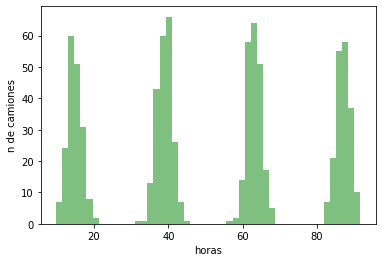

In [37]:
df = pd.read_csv("../data/router_arrival200.txt")
plt.hist(df["arrival_time"],50, density=False, facecolor='g', alpha=0.5)
plt.xlabel("horas")
plt.ylabel("n de camiones")

## Barrier

## Gate

Una pregunta que nos hicimos es como modelamos el tiempo de procesado del camion. En la realidad las gates tienen cierta cantidad de trabajadores que procesan el camion. Hay trabajadores turno mañana y turno noche. 

Internamente dentro de la gate simulamos el proceso de multiples trabajadores procesando gates en paralelo. El tiempo procesado de cada paquete por un trabajador sigue una gaussiana que depende del tipo de paquete.

A su vez, cada gate tiene un tiempo de actividad en el que se encuentra disponible para procesar camiones y un tiempo en el que se encuentra ```UNAVAILABLE``` y por lo tanto no puede procesar camiones.

A grandes rasgos la gate tiene 3 estados. 
- ```UNAVAILABLE```. Cuando la gate se encuentra cerrada
- ```BUSY```. Cuando la gate se encuentra procesando un paquete
- ```FREE``` Cuando la gate se encuentra disponible

<p align="center">
    <img src="gate.png"  width="700"/>
</p>

Hay ciertas sutilezas involucradas para mantenerse abierto una vez que te levanto el manger. En resumidas cuentas cuando te levanta el manager hay que ser cuidadoso para que no se vaya a UNAVAILABLE inmediatamente ya que se encuentra fuera de horario.

Otra cosa que modelamos es que cuando el manager envia un mensaje a una gate abierta le de un "boost" a su velocidad de procesado. Este boost va decayendo exponencialmente a medida que pasa el tiempo

### Analisis del tiempo de procesado en base a la cantidad de workers

Un analisis previo que hicimos es ver como afecta el tiempo de procesado cuando se tiene distinta cantidad de workers.

In [57]:
df = pd.read_csv("../data/processing_time_by_workers.txt")


El tiempo de procesado es una variable aleatoria por lo que vemos las distribuciones para distinta cantidad de workers

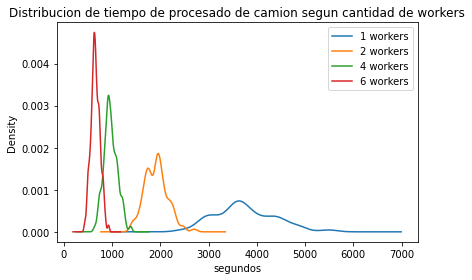

In [58]:
for n in [1,2,4,6]:
    a = df[df["workers"] == n ]
    a["processing_time"].plot.kde(label=str(n) + " workers")
plt.xlabel("segundos")
plt.title('Distribucion de tiempo de procesado de camion segun cantidad de workers')
plt.tight_layout()
plt.legend()


Vemos que para cantidades de workers << paquetes por camion el tiempo decrece inversamente con la cantidad de workers

Tambien analaizamos como cambia el througput con distinta cantidad de workers. Es decier la cantidad de camiones por hora que se pueden procesar con esa cantidad de workers

In [59]:
import seaborn as sns

Text(0.5, 1.0, 'Camiones por hora segun cantidad de workers')

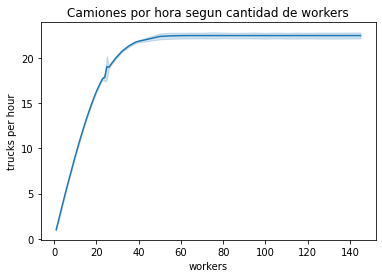

In [66]:
sns.lineplot(data=df, x="workers", y="trucks per hour",)
plt.title('Camiones por hora segun cantidad de workers')

Como sospechabamos, la efectividad de agregar mas trabajadores disminuye rapidamente cuando se tiene una gran cantidad de workers acercandose a aprox 22 camiones/horas. Naturalmente en nuestro modelo la cantidad de workers varia en valores pequeños pero resultaba interesante observar el comportamiento para grandes cantidades de trabajadores.

Ademas esto sirve para obtener una cota superior a la cantidad de camiones por dia que pueden llegar para que no sature:

$$ \text{cota saturacion} = \sum_{\text{gate}} 22 \text{ camiones/hora} \cdot \text{tiempo activo(gate)}))$$

Con 10 gates abiertas las 24 horas esto equivaldria a 5280 camiones por dia

## Manager

In [ ]:
from pathlib import Path

SED_HOME = Path.home().joinpath('Documents').joinpath('sed')
CDPP_DIR = SED_HOME.joinpath('CDPP')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

In [2]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/dc-sed-tp1-2022/model/

cat top.ma

[top]
components : router@router barrier@barrier manager@manager queue@queue transducer@transducer gate1@gate gate2@gate gate3@gate gate4@gate gate5@gate gate6@gate gate7@gate gate8@gate gate9@gate gate10@gate
out : out

link : out@router in@queue
link : outId@router arrived@transducer
link : out@queue in@barrier
link : throughput@transducer in@manager

link : done@barrier done@queue
link : done@barrier solved@transducer

link : out1@barrier fromBarrier@gate1
link : out2@barrier fromBarrier@gate2
link : out3@barrier fromBarrier@gate3
link : out4@barrier fromBarrier@gate4
link : out5@barrier fromBarrier@gate5
link : out6@barrier fromBarrier@gate6
link : out7@barrier fromBarrier@gate7
link : out8@barrier fromBarrier@gate8
link : out9@barrier fromBarrier@gate9
link : out10@barrier fromBarrier@gate10

link : toBarrier@gate1 done1@barrier
link : toBarrier@gate2 done2@barrier
link : toBarrier@gate3 done3@barrier
link : toBarrier@gate4 done4@barrier
link : toBarrier@gate5 done5@barrier
link :

In [3]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/dc-sed-tp1-2022/src/

bin/cd++ -m ../model/top.ma  \
         -l ../top.log \
         -o ../top.out \
         -t 240:00:00:00

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from ../model/top.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: ../top.log
Output to: ../top.out
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision =

# Resultados

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# definimos los path a los archivos de interés
OUT_FILENAME = str(CDPP_EXAMPLES)+"/dc-sed-tp1-2022/top.out"

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'

# conversion a floar
def parse_value(value: str):
    is_list = value.strip().startswith("[") and value.strip().endswith("]")
    if is_list:
        return tuple(float(num) for num in value.replace('[', '').replace(']', '').split(', '))
    return float(value)

# conversion VTime a float
def time_to_secs(time):
    h, m, s, ms, r = time.split(':')
    return float(h)*60*60. + float(m)*60. + float(s) + float(ms)/1000. + float(r)/1000.

In [5]:
df_converters = {
    VALUE_COL: parse_value,
    TIME_COL: time_to_secs
}

salida = pd.read_csv(OUT_FILENAME,
                     delimiter=r'(?<!,)\s+',
                     engine='python',  # C engine doesnt work for regex
                     # Se puede usar esto para convertir los valores directamente:
                     converters=df_converters,
                     names=[TIME_COL, PORT_COL, VALUE_COL]
                    )
salida

,time,port,value
0,37685.669791,out,"(0.0, 35920.6, 35921.6, 37685.7, 58.0, 47.0, 5..."
1,39042.726895,out,"(2.0, 37517.7, 37518.7, 39042.7, 52.0, 65.0, 5..."
2,39083.052884,out,"(1.0, 37430.4, 37431.4, 39083.1, 49.0, 50.0, 5..."
3,39720.205586,out,"(3.0, 37940.6, 37941.6, 39720.2, 60.0, 53.0, 4..."
4,39830.025520,out,"(4.0, 38484.9, 38485.9, 39830.0, 51.0, 50.0, 4..."
...,...,...,...
170,68303.522702,out,"(170.0, 66801.5, 66802.5, 68303.5, 51.0, 50.0,..."
171,69262.372763,out,"(172.0, 68302.9, 68303.9, 69262.4, 39.0, 34.0,..."
172,69781.188853,out,"(171.0, 68037.6, 68038.6, 69781.2, 61.0, 37.0,..."
173,70546.182873,out,"(173.0, 69262.0, 69263.0, 70546.2, 50.0, 54.0,..."


In [6]:
salida[['route_id', 'arrival_date', 'assigned_date', 'exit_date', 'count_A', 'count_B', 'count_C']] = pd.DataFrame(salida['value'].tolist(), index=salida.index)
salida = salida.drop(['value'], axis=1)
salida

,time,port,route_id,arrival_date,assigned_date,exit_date,count_A,count_B,count_C
0,37685.669791,out,0.0,35920.6,35921.6,37685.7,58.0,47.0,52.0
1,39042.726895,out,2.0,37517.7,37518.7,39042.7,52.0,65.0,51.0
2,39083.052884,out,1.0,37430.4,37431.4,39083.1,49.0,50.0,59.0
3,39720.205586,out,3.0,37940.6,37941.6,39720.2,60.0,53.0,43.0
4,39830.025520,out,4.0,38484.9,38485.9,39830.0,51.0,50.0,47.0
...,...,...,...,...,...,...,...,...,...
170,68303.522702,out,170.0,66801.5,66802.5,68303.5,51.0,50.0,61.0
171,69262.372763,out,172.0,68302.9,68303.9,69262.4,39.0,34.0,49.0
172,69781.188853,out,171.0,68037.6,68038.6,69781.2,61.0,37.0,48.0
173,70546.182873,out,173.0,69262.0,69263.0,70546.2,50.0,54.0,51.0


<AxesSubplot:xlabel='arrival_date'>

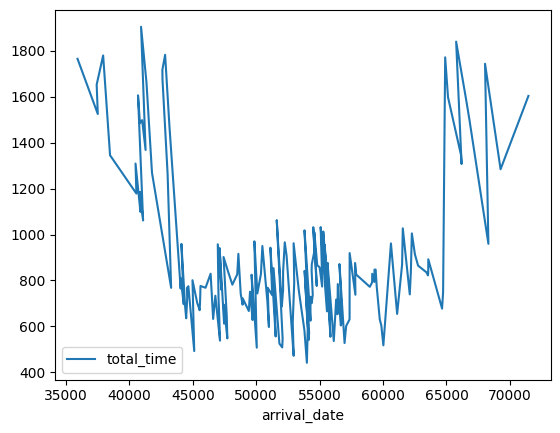

In [7]:
salida['total_time'] = salida['exit_date'] - salida['arrival_date']
salida.plot(x='arrival_date', y='total_time')